**Étapes pour utiliser le code :**

1. Préparez votre dataset comme décrit, avec les images dans un dossier et le fichier CSV des labels.

2. Mettez à jour les variables DATA_DIR, CSV_FILE, IMAGE_DIR, et surtout la liste EMOTION_LABELS pour qu'elle corresponde exactement à vos émotions et l'ordre de vos colonnes dans le CSV.

3. Exécutez le script.

4. Surveillez la console pour les métriques d'entraînement et de validation. Ajustez les hyperparamètres (BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, FREEZE_FEATURES) si nécessaire en fonction des performances observées.

**Organisation des données :**

your_dataset/

├── images/

│   ├── image_001.jpg

│   ├── image_002.jpg

│   └── ...

└── labels.csv # Ou un autre format de fichier, contenant les chemins d'images et leurs étiquettes

**Format du dataset :**

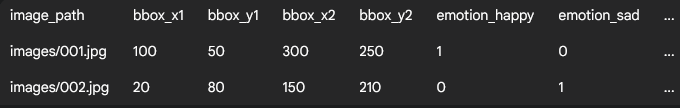

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models#, transforms
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
import numpy as np
from tqdm import tqdm # Pour les barres de progression

#import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.5.1+cu121'

On a le choix de fine tuner la dernière couche OU tout le modele (pas le même temps)

# I/ Configuration et Hyperparamètres 

In [4]:
# --- 0. Configuration et Hyperparamètres ---
DATA_DIR = r'C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic' # Chemin vers votre dossier racine du dataset
CSV_FILE = os.path.join(DATA_DIR, 'labels.csv') # Chemin vers votre fichier CSV d'étiquettes
IMAGE_DIR = os.path.join(DATA_DIR, 'images') # Chemin vers le dossier contenant les images

BODY_BBOX_COLS = ['body_bbox_x1', 'body_bbox_y1', 'body_bbox_x2', 'body_bbox_y2'] # Noms de vos colonnes de face_box dans le CSV

# Définissez vos émotions binaires ici, dans le même ordre que vos colonnes dans le CSV
EMOTION_LABELS = [
    'Disconnection',
    'Doubt/Confusion',
    'Fatigue',
    'Pain',
    'Disquietment',
    'Annoyance',
    'others',
    'adhd_emotion'
]

NUM_CLASSES = len(EMOTION_LABELS)

BATCH_SIZE = 32 
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
FREEZE_FEATURES = True # True pour ne fine-tuner que la dernière couche, False pour fine-tuner tout le modèle

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {DEVICE}")

Utilisation du périphérique : cuda:0


In [5]:
print(DATA_DIR)
print(CSV_FILE)
print(IMAGE_DIR)

C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic
C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic\labels.csv
C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic\images


In [6]:
# Charger le fichier CSV des annotations
df = pd.read_csv(CSV_FILE)

# Vérifie qu'une colonne 'image' ou 'filename' existe
assert 'image' in df.columns or 'filename' in df.columns, "❌ Le fichier CSV ne contient pas de colonne 'image' ou 'filename'."

# Nom de la colonne contenant les noms d'image
image_column = 'image' if 'image' in df.columns else 'filename'

# Vérification de l'existence des fichiers image
missing_images = []
for img_name in df[image_column].unique():
    img_path = os.path.join(IMAGE_DIR, img_name)
    if not os.path.isfile(img_path):
        missing_images.append(img_name)

# Affichage du résultat
if missing_images:
    print(f"❌ {len(missing_images)} image(s) manquante(s) sur {df[image_column].nunique()} :")
    print(missing_images[:10])  # Affiche les 10 premières si la liste est longue
else:
    print("✅ Toutes les images référencées dans le CSV sont présentes dans le dossier images/")


✅ Toutes les images référencées dans le CSV sont présentes dans le dossier images/


# II/ Création du Dataset PyTorch personnalisé (modifié)

In [ ]:
# --- 1. Création du Dataset PyTorch personnalisé (modifié) ---
class EmotionDataset(Dataset):
    def __init__(self, df, img_dir, emotion_cols, bbox_cols, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.emotion_cols = emotion_cols
        self.bbox_cols = bbox_cols # Nouvelle ligne pour les colonnes de la bbox

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'])

        emotion_labels = row[self.emotion_cols].values.astype(float)
        emotion_labels = torch.tensor(emotion_labels, dtype=torch.float32)

        image = Image.open(img_path).convert('RGB')
        x1, y1, x2, y2 = row[self.bbox_cols].values.astype(int)
        cropped_image = image.crop((x1, y1, x2, y2))
        
        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, emotion_labels

In [ ]:
# Chargement du CSV
df = pd.read_csv(CSV_FILE)

# Prendre une ligne aléatoire
sample_row = df.sample(1).iloc[0]
img_name = sample_row['image']  # colonne contenant le nom du fichier image
img_path = os.path.join(IMAGE_DIR, img_name)

print(f"Test de lecture de l'image : {img_path}")

# Mesure du temps de lecture
start = time.time()
try:
    img = Image.open(img_path).convert('RGB')
    img.load()  # Force le chargement complet
    print(f"✅ Image lue correctement. Taille = {img.size}")
except Exception as e:
    print(f"❌ Erreur de lecture de l'image : {e}")

end = time.time()
print(f"⏱ Temps de lecture : {end - start:.4f} secondes")


Test de lecture de l'image : C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic\images\COCO_train2014_000000370524.jpg
✅ Image lue correctement. Taille = (640, 495)
⏱ Temps de lecture : 0.0110 secondes


# III/ Transformations d'images

In [10]:
# --- 2. Transformations d'images ---
# Transformations pour l'entraînement (augmentation des données)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Recadrage aléatoire et redimensionnement à 224x224
        transforms.RandomHorizontalFlip(), # Retournement horizontal aléatoire
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Jitter de couleur
        transforms.ToTensor(), # Convertir en Tensor PyTorch (met les pixels entre 0 et 1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation (moyenne et std ImageNet)
    ]),
    # Transformations pour la validation/test (juste redimensionnement et normalisation)
    'val': transforms.Compose([
        transforms.Resize(256), # Redimensionner le plus petit côté à 256
        transforms.CenterCrop(224), # Centre Crop à 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

c:\Users\alber\anaconda3\envs\dl_project_py311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# IV/ Chargement des données et division Train/Val 

In [ ]:
# --- 3. Chargement des données et division Train/Val ---
print("Chargement des données...")
full_df = pd.read_csv(CSV_FILE)

# Division du dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['adhd_emotion'] if True else None) # Stratify si possible

train_dataset = EmotionDataset(df=train_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['train'])
val_dataset = EmotionDataset(df=val_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Taille du dataset d'entraînement : {dataset_sizes['train']}")
print(f"Taille du dataset de validation : {dataset_sizes['val']}")

Chargement des données...
Taille du dataset d'entraînement : 13516
Taille du dataset de validation : 3380


In [12]:
train_dataset[0]  # ou un autre index si ça bloque toujours

(tensor([[[-1.3815, -1.3815, -1.3644,  ..., -1.4329, -1.4329, -1.4329],
          [-1.3815, -1.3815, -1.3644,  ..., -1.4329, -1.4329, -1.4329],
          [-1.3815, -1.3815, -1.3815,  ..., -1.4329, -1.4329, -1.4329],
          ...,
          [ 0.7419,  0.7419,  0.7419,  ..., -0.3198, -0.2856, -0.2856],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.3369, -0.3027, -0.3027],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.3369, -0.3027, -0.3027]],
 
         [[-1.2829, -1.2829, -1.2829,  ..., -1.3704, -1.3704, -1.3704],
          [-1.2829, -1.2829, -1.2829,  ..., -1.3704, -1.3704, -1.3704],
          [-1.3004, -1.3004, -1.2829,  ..., -1.3704, -1.3704, -1.3704],
          ...,
          [ 0.8354,  0.8354,  0.8354,  ..., -0.1800, -0.1275, -0.1275],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.1975, -0.1450, -0.1450],
          [ 0.8179,  0.8179,  0.8179,  ..., -0.1975, -0.1450, -0.1450]],
 
         [[-0.9853, -0.9853, -0.9678,  ..., -1.0898, -1.0898, -1.0898],
          [-0.9853, -0.9853,

In [13]:
next(iter(val_loader))

[tensor([[[[ 0.6734,  0.5364,  0.3481,  ...,  2.1804,  2.1462,  2.1119],
           [ 0.7248,  0.6221,  0.4679,  ...,  2.1633,  2.1633,  2.1462],
           [ 0.7933,  0.6906,  0.5878,  ...,  2.1119,  2.1462,  2.1633],
           ...,
           [ 0.5878,  0.5707,  0.5878,  ..., -1.2959, -1.3473, -1.3815],
           [ 0.6049,  0.5878,  0.6049,  ..., -1.1760, -1.2445, -1.3130],
           [ 0.6049,  0.5878,  0.6049,  ..., -1.0904, -1.1589, -1.2103]],
 
          [[ 0.8004,  0.6779,  0.5203,  ...,  1.2381,  1.2206,  1.1856],
           [ 0.9055,  0.7829,  0.6429,  ...,  1.2381,  1.2206,  1.2031],
           [ 0.9755,  0.8704,  0.7654,  ...,  1.2031,  1.2031,  1.2206],
           ...,
           [ 0.3102,  0.2402,  0.2052,  ..., -1.7556, -1.7906, -1.7906],
           [ 0.3277,  0.2577,  0.2227,  ..., -1.6856, -1.7381, -1.7906],
           [ 0.3277,  0.2752,  0.2402,  ..., -1.6331, -1.6681, -1.7206]],
 
          [[ 1.1585,  1.0539,  0.9145,  ...,  1.2980,  1.2631,  1.2457],
           [ 

In [14]:
next(iter(train_loader))

[tensor([[[[-1.4329, -1.4329, -1.4329,  ..., -1.0562, -1.0390, -1.0390],
           [-1.4329, -1.4329, -1.4329,  ..., -1.0562, -1.0390, -1.0390],
           [-1.4500, -1.4500, -1.4329,  ..., -1.0733, -1.0390, -1.0390],
           ...,
           [-1.5870, -1.5870, -1.5870,  ...,  0.3994,  0.3994,  0.3994],
           [-1.5870, -1.5870, -1.5870,  ...,  0.3994,  0.3994,  0.3994],
           [-1.5870, -1.5870, -1.5870,  ...,  0.3994,  0.3994,  0.3994]],
 
          [[-1.5980, -1.5980, -1.5980,  ..., -1.3179, -1.3004, -1.3004],
           [-1.5980, -1.5980, -1.5980,  ..., -1.3179, -1.3004, -1.3004],
           [-1.6155, -1.6155, -1.6155,  ..., -1.3354, -1.3004, -1.3004],
           ...,
           [-1.8081, -1.8081, -1.8081,  ..., -0.1975, -0.1975, -0.1975],
           [-1.8081, -1.8081, -1.8081,  ..., -0.1975, -0.1975, -0.1975],
           [-1.8081, -1.8081, -1.8081,  ..., -0.1975, -0.1975, -0.1975]],
 
          [[-1.5779, -1.5779, -1.5779,  ..., -1.2990, -1.2641, -1.2641],
           [-

In [15]:
# --- Test 0 : Vérifie si le DataLoader donne quelque chose ---
print("Test du premier batch dans val_loader...")

try:
    sample_batch = next(iter(val_loader))
    images, labels = sample_batch
    print(f"Batch chargé : {images.shape} - {labels.shape}")
except Exception as e:
    print("Erreur pendant le chargement du batch :", e)


Test du premier batch dans val_loader...
Batch chargé : torch.Size([32, 3, 224, 224]) - torch.Size([32, 8])


In [16]:
# --- Test 1 : Vérifie si le DataLoader donne quelque chose ---
print("Test du premier batch dans train_loader...")

try:
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    print(f"Batch chargé : {images.shape} - {labels.shape}")
except Exception as e:
    print("Erreur pendant le chargement du batch :", e)


Test du premier batch dans train_loader...
Batch chargé : torch.Size([32, 3, 224, 224]) - torch.Size([32, 8])


In [17]:
import time
import torch

# Active le DataLoader uniquement
print("⏳ Test de vitesse du train_loader...")

n_batches_to_test = 20  # Tu peux ajuster selon la taille de ton dataset
total_load_time = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, (inputs, labels) in enumerate(train_loader):
    if i >= n_batches_to_test:
        break

    start = time.time()

    # Envoie au GPU (si utile pour tester l'impact)
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Attendre que les données soient vraiment transférées
    torch.cuda.synchronize() if device.type == "cuda" else None

    end = time.time()
    load_time = end - start
    total_load_time += load_time
    print(f"🧱 Batch {i+1} - Temps de chargement + transfert : {load_time:.4f} sec")

print("\n📊 Moyenne sur", n_batches_to_test, "batches :")
print(f"⏱ Temps moyen par batch : {total_load_time / n_batches_to_test:.4f} sec")


⏳ Test de vitesse du train_loader...
🧱 Batch 1 - Temps de chargement + transfert : 0.1370 sec
🧱 Batch 2 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 3 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 4 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 5 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 6 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 7 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 8 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 9 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 10 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 11 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 12 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 13 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 14 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 15 - Temps de chargement + transfert : 0.0030 sec
🧱 Batch 16 - Temps de chargement + transfert : 0.0040 sec
🧱 Batch 17 - Temps de chargement + transfert

In [18]:
for i in range (2):
    print(train_dataset[i])

(tensor([[[ 0.9988,  0.9988,  0.9988,  ...,  1.2557,  1.1872,  1.1700],
         [ 0.9817,  0.9817,  0.9817,  ...,  1.1187,  1.1187,  1.1358],
         [ 0.9817,  0.9817,  0.9817,  ...,  1.0159,  1.0159,  1.0331],
         ...,
         [-0.9192, -0.8849, -0.7822,  ...,  0.7077,  0.7077,  0.7077],
         [-0.8849, -0.9020, -0.7822,  ...,  0.7248,  0.7248,  0.7248],
         [-0.8678, -0.8849, -0.7993,  ...,  0.7419,  0.7419,  0.7419]],

        [[ 1.1331,  1.1331,  1.1331,  ...,  1.3256,  1.2906,  1.2906],
         [ 1.0805,  1.0805,  1.0805,  ...,  1.2031,  1.2381,  1.2381],
         [ 1.0805,  1.0805,  1.0805,  ...,  1.1331,  1.1331,  1.1331],
         ...,
         [-0.8627, -0.8452, -0.7752,  ...,  0.9055,  0.9055,  0.9055],
         [-0.8277, -0.8627, -0.7927,  ...,  0.9405,  0.9405,  0.9405],
         [-0.8102, -0.8452, -0.7927,  ...,  0.9580,  0.9580,  0.9580]],

        [[ 2.0648,  2.0648,  2.0648,  ...,  2.1171,  2.1346,  2.1520],
         [ 2.0300,  2.0300,  2.0300,  ...,  

# V/ Chargement du modèle ResNet18 pré-entraîné

In [19]:
print("Chargement et modification du modèle ResNet18 pré-entraîné...")

# 1. Chargement du modèle ResNet18 pré-entraîné sur ImageNet
model_ft = models.resnet18(weights="IMAGENET1K_V1")

print("Freeze des couches convolutionnelles...")

# 2. On gèle les couches de feature extraction
for param in model_ft.parameters():
    param.requires_grad = False

print("Définition de la dernière couche...")

# 3. Remplacement de la couche fully-connected finale
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),   # Couche cachée intermédiaire
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES),  # Sortie adaptée au nombre d’émotions
    nn.Sigmoid()  # Activation pour classification multi-label
)

# 4. Envoi du modèle sur le bon device (GPU ou CPU)
model_ft = model_ft.to(DEVICE)

print("Modèle prêt ! ✅")


Chargement et modification du modèle ResNet18 pré-entraîné...
Freeze des couches convolutionnelles...
Définition de la dernière couche...
Modèle prêt ! ✅


In [21]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
from torchinfo import summary

# Print model summary
#summary(model_ft, input_size=(8, 3, 224, 224))  # (batch_size, input_features)
summary(model_ft, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 8]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

# VI/ Fonction de perte et Optimiseur

In [23]:
# --- 5. Fonction de perte et Optimiseur ---
# Pour la classification multi-label, Binary Cross-Entropy with Logits Loss est la norme.
# Elle combine une couche Sigmoid et la Binary Cross-Entropy.
# Perte pour la classification multi-label des émotions

# criterion_emotions = nn.BCEWithLogitsLoss()
# criterion_emotions = nn.CrossEntropyLoss()
criterion_emotions = nn.BCELoss()

# Seulement les paramètres qui nécessitent des gradients seront optimisés
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Ordonnanceur de taux d'apprentissage (réduit le LR après un certain nombre d'époques)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# VII/ Fonction d'entraînement et d'évaluation

In [26]:
# --- 6. Fonction d'entraînement et d'évaluation ---
import time

def train_model(model, criterion_emotions, optimizer, train_loader, val_loader, device, scheduler=None, epochs=NUM_EPOCHS):
    
    since = time.time()
    
    history = {'train_loss': [], 'val_loss': [],'train_acc': [], 'val_acc': []}

    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 30)

        ### -------- TRAIN --------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion_emotions(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)
            
            # Accuracy multi-label (threshold 0.5)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_corrects += (preds == labels).float().sum().item()
            total_samples += labels.numel()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / total_samples

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        ### -------- VAL --------
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion_emotions(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_corrects += (preds == labels).float().sum().item()
                val_total += labels.numel()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects / val_total

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f} | Acc: {val_epoch_acc:.4f}")

        if scheduler:
            scheduler.step()

    time_elapsed = time.time() - since
    print(f"\n🕒 Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    return history


In [27]:
history = train_model(model=model_ft,
                        criterion_emotions=criterion_emotions,
                        optimizer=optimizer_ft,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        device=DEVICE,
                        scheduler=exp_lr_scheduler,
                        epochs=10)



Epoch 1/10
------------------------------
Train Loss: 0.1702 | Acc: 0.1545
Val   Loss: 0.1585 | Acc: 0.1544

Epoch 2/10
------------------------------
Train Loss: 0.1634 | Acc: 0.1545
Val   Loss: 0.1598 | Acc: 0.1544

Epoch 3/10
------------------------------
Train Loss: 0.1630 | Acc: 0.1545
Val   Loss: 0.1645 | Acc: 0.1544

Epoch 4/10
------------------------------
Train Loss: 0.1616 | Acc: 0.1545
Val   Loss: 0.1564 | Acc: 0.1544

Epoch 5/10
------------------------------
Train Loss: 0.1613 | Acc: 0.1545
Val   Loss: 0.1571 | Acc: 0.1544

Epoch 6/10
------------------------------
Train Loss: 0.1610 | Acc: 0.1545
Val   Loss: 0.1570 | Acc: 0.1544

Epoch 7/10
------------------------------
Train Loss: 0.1607 | Acc: 0.1545
Val   Loss: 0.1558 | Acc: 0.1544

Epoch 8/10
------------------------------
Train Loss: 0.1564 | Acc: 0.1545
Val   Loss: 0.1568 | Acc: 0.1544

Epoch 9/10
------------------------------
Train Loss: 0.1572 | Acc: 0.1545
Val   Loss: 0.1552 | Acc: 0.1544

Epoch 10/10
------

# VIII/ Lancement de l'entraînement 

In [ ]:
# # --- 7. Lancement de l'entraînement ---
# print("\nDébut de l'entraînement...")
# model_ft = train_model(model_ft, criterion_emotions, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

In [38]:
import onnx

In [39]:
# Chemin de sauvegarde
onnx_export_path = "emotic_model.onnx"

# Dummy input — doit correspondre à la taille attendue par ton modèle
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)

# Export ONNX
torch.onnx.export(
    model_ft,                  # Le modèle entraîné
    dummy_input,               # Un exemple d'input
    onnx_export_path,          # Chemin de sortie
    input_names=['input'],     # Nom de l'input
    output_names=['output'],   # Nom de la sortie
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11,          # Version de l'opset ONNX (11 est sûr pour la compatibilité)
    do_constant_folding=True   # Optimisation pour les constantes
)

print(f"✅ Modèle exporté au format ONNX : {onnx_export_path}")


✅ Modèle exporté au format ONNX : emotic_model.onnx


In [ ]:
# # --- 8. Sauvegarde du modèle entraîné ---
# # Créez un dossier pour les modèles si n'existe pas
# os.makedirs('saved_models', exist_ok=True)
# model_save_path = os.path.join('saved_models', 'resnet18_emotion_dav_multi_person.pth')
# torch.save(model_ft.state_dict(), model_save_path)
# print(f"Modèle sauvegardé à : {model_save_path}")

In [ ]:
# --- 9. (Optionnel) Évaluation finale sur l'ensemble de validation ---
# Charger le modèle pour l'évaluation
# model_ft.eval() # Mettre en mode évaluation
# ... Vous pouvez réutiliser le code d'évaluation de la fonction train_model ici si vous voulez une évaluation finale séparée.

print("\n--- Entraînement terminé ---")

In [ ]:
# import onnxruntime as ort
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# # Charger le modèle ONNX
# session = ort.InferenceSession("emotic_model.onnx")

# # Charger et prétraiter une image
# img_path = "chemin/vers/image.jpg"
# image = Image.open(img_path).convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])

# input_tensor = transform(image).unsqueeze(0).numpy()  # (1, 3, 224, 224)

# # Faire une prédiction
# outputs = session.run(['output'], {'input': input_tensor})
# preds = outputs[0]

# # Résultat
# print("Prédiction brute :", preds)
